# Time Series Project

En la primera etapa nos ocupamos de cargar los datos

# CARGANDO EL DATASET (DATA FEED)

In [1]:
import pandas as pd  # codding
import pandas  # for annotations

import warnings

warnings.filterwarnings("ignore")

from paquete_proyecto.iniciando.bases import importar_databases
from paquete_proyecto.herramientas.data_info import data_info

In [2]:
ventas, ventas_sin_duplicados = importar_databases()

La longitud de la serie Nº 1 es de: 127255
La longitud de la serie Nº 2 es de: 108794


In [3]:
display(ventas.sample(3))
data_info(ventas, "ventas")

,IdCliente,NombreCliente,Empleado,Referencia,Descripcion,CodigoFamilia,Familia,Cantidad,Ventas,Localidad,Sede,Area
Fecha,,,,,,,,,,,,
2017-06-23,C860013704-3,CRYOGAS,38.0,SE-CS-3-0002,MONTAJE CAMION,106.0,SERVICIOS,1,8403,Puente aranda,Calle 13,35.0
2017-02-14,C900364615,ORGANIZACION SUMA SAS,2.0,REC-0031,REENC XZE2 11 R 22.5,102.0,REENCAUCHE,1,619,Engativa,Ventas externas,22.0
2016-12-20,C4065131,PASTRAN WILLIAM,10.0,SE-CS-1-0001,ALINEACION AUTO,106.0,SERVICIOS,1,30172,Engativa,Calle 80,31.0


info de ventas,columna,type,count,NaN,NaN_pct,unique,unique_pct
0,IdCliente,object,127255,0,0.0 %,24122,18.96 %
1,NombreCliente,object,127255,0,0.0 %,21840,17.16 %
2,Empleado,float64,127255,0,0.0 %,56,0.04 %
3,Referencia,object,127255,0,0.0 %,1854,1.46 %
4,Descripcion,object,127255,0,0.0 %,1814,1.43 %
5,CodigoFamilia,float64,127255,0,0.0 %,5,0.0 %
6,Familia,object,127255,0,0.0 %,5,0.0 %
7,Cantidad,object,127255,0,0.0 %,213,0.17 %
8,Ventas,object,127255,0,0.0 %,14279,11.22 %
9,Localidad,object,127255,0,0.0 %,6,0.0 %


<div>
    <h4>Evaluación de cada columna</h4>
    <ol>
        <li> <b>IdCliente</b>: object - código alfanumérico</li><br />
        <li> <b>NombreCliente</b>: object - string = Nombre, Apellido</li><br />
        <li> <b>>> Empleado</b>: float - cambiar a int</li><br />
        <li> <b>Referencia</b>: object: categoría ordinal</li><br />
        <li> <b>Descripcion</b>: object: categoria cualitativa </li><br />
        <li> <b>>> CodigoFamilia</b>: float64: Cambiar a int</li><br />
        <li> <b>Familia</b>: object: categoria cualitativa</li><br />
        <li> <b>>>Cantidad</b>: object: cambiar a int</li><br />
        <li> <b>>> Ventas</b>: int: cambiar a float</li><br />
        <li> <b>Localidad</b>: object: categoria bussines</li><br />
        <li> <b>>> Area</b>: float: cambiar a int</li><br />
    </ol>
</div>

In [4]:
from paquete_proyecto.iniciando.variables import ajustar_tipos

In [5]:
data, ventas_sin_duplicados = ajustar_tipos(ventas), ajustar_tipos(
    ventas_sin_duplicados
)

# COMPLETANDO EL DATASET (DATA PREPARE)

    1- AJUSTAR "Ventas" A LA COTIZACION DEL "USD"
    2- COMPLETAR LAS FECHAS FALTANTES
    3- DIVIDIR DATASET EN MUESTRAS (Para generar rankings)



------BORRAR------

Primero tenemos que armar cada una de las series temporales

Para poder aplicar Cross-Validation a la serie temporal, es necesario completar con las fechas faltantes con algun valor default en sus variables. De esta forma podremos garantizar que nuestro folds representan el mismo timedelta.

## 2- AJUSTAR COTIZACION

In [6]:
from paquete_proyecto.prepocesamiento.forex_api import alpha_vantage_fx_api
import os
from dotenv import load_dotenv

load_dotenv()

True

In [7]:
TOKEN = os.environ["TOKEN_AV"]

cotizacion = alpha_vantage_fx_api("FX_WEEKLY", "COP", "USD", TOKEN)

In [8]:
cotizacion.sort_index(ascending=True, inplace=True)

In [9]:
# Acá quiero separa el periodo que corresponde al dataset que estoy trabajando. con min max en el indice
cotizacion = cotizacion[data.index.min(): data.index.max()]

# Acá voy a tomar un criterio de unificación de valores
# el indice marca el limite final de las fechas que engloba hacia atras
# el valor que se toma es el valor de apertura

cotizacion.loc[:, "COP/USD"] = cotizacion['1. open']
cotizacion = cotizacion["COP/USD"].to_frame()
cotizacion.dtypes

COP/USD    float64
dtype: object

In [23]:
cotizacion

,COP/USD
2016-01-15,0.00030
2016-01-22,0.00030
2016-01-29,0.00031
2016-02-05,0.00030
2016-02-12,0.00030
...,...
2020-10-30,0.00026
2020-11-06,0.00026
2020-11-13,0.00027
2020-11-20,0.00027


In [24]:
# Acá quiero subdividir el dataset original, en función de los datos del dataset obtenido
def agregar_cotizacion(data, cotizacion):
    for i in range(len(cotizacion)):
        if i == 0:
            data.loc[:cotizacion.index[i], 'Cotizacion_USD'] = cotizacion.iloc[i].values[0]
            continue

        data.loc[cotizacion.index[i-1]:cotizacion.index[i], 'Cotizacion_USD'] = cotizacion.iloc[i].values[0]

    return data


agregar_cotizacion(data, cotizacion).head(10)

# Acá quiero crear una columna en el dataset original con la cotización del dolar durante esa fecha

# Acá quiero crear otra columna que sea el valor de las ventas expresados en usd

,IdCliente,NombreCliente,Empleado,Referencia,Descripcion,CodigoFamilia,Familia,Cantidad,Ventas,Localidad,Sede,Area,cotizacion
Fecha,,,,,,,,,,,,,
2016-01-09,C1070956433,PINTO JOHN,24.0,LL-2R-0038,PILOT STREET 110/80-17,101.0,LLANTA,1.0,129310.0,Puente aranda,Calle 13,35.0,0.0003
2016-01-09,C19347046,RUIZ LUIS FERNANDO,10.0,SE-CS-2-0001,BALANCEO AUTO,106.0,SERVICIOS,4.0,31035.0,Engativa,Calle 80,31.0,0.0003
2016-01-09,C800232717,CORSO Y CIA S EN C,10.0,SE-CS-2-0002,BALANCEO CAMIONETA,106.0,SERVICIOS,4.0,31034.0,Engativa,Calle 80,31.0,0.0003
2016-01-09,C79523685,GONZALEZ JUAN CARLOS,10.0,SE-CS-2-0002,BALANCEO CAMIONETA,106.0,SERVICIOS,4.0,31034.0,Engativa,Calle 80,31.0,0.0003
2016-01-09,C800214037,EXPRESER SAS,5.0,REB-0063,REENC XZE1 235/75R17.5,102.0,REENCAUCHE,1.0,29892.0,Engativa,Ventas externas,22.0,0.0003
2016-01-09,C79349613,ANTONIO ROJAS MARCO,10.0,SE-CS-12-0007,SUSPENSION MANO DE OBRA X HORA,106.0,SERVICIOS,1.0,30172.0,Engativa,Calle 80,31.0,0.0003
2016-01-09,C19091837,URIBE GABRIEL,12.0,SE-CS-11-0001,RECTIFICACION RIN LAMINA,106.0,SERVICIOS,1.0,30172.0,Usaquen,Santa ana,33.0,0.0003
2016-01-09,C79295843,GOMEZ FRANCISCO,12.0,SE-CS-1-0001,ALINEACION AUTO,106.0,SERVICIOS,1.0,30172.0,Usaquen,Santa ana,33.0,0.0003
2016-01-09,C19347046,RUIZ LUIS FERNANDO,10.0,SE-CS-1-0001,ALINEACION AUTO,106.0,SERVICIOS,1.0,30172.0,Engativa,Calle 80,31.0,0.0003


## 1- COMPLETAR FECHAS FALTANTES

In [12]:
from paquete_proyecto.prepocesamiento.inicial import complete_dates

In [13]:
data = complete_dates(ventas)

## 3- ARMANDO MUESTREOS TEMPORALES

Vamos a hacer cross validation con scikit learn sobre un DataFrame:

Si empezamos por 2016-01-09 y terminamos en 2020-12-02, tenemos 1790 días.

Como querémos cortes de igual tamaño, y sin gap al max_train_size y al test_size le damos el mismo valor.

Como queremos cortes bimensuales ingresamos los parámetros con valor 60.

Para n_splits hacemos 1790 / 60 = 29.8 por eso elegimos 29 folds.

In [14]:
from paquete_proyecto.prepocesamiento.inicial import timeseries_cv

In [15]:
lista_mensual = timeseries_cv(data, 59, 30, 30)

## visualizar población lista_mensual

[Text(0.5, 1.0, 'Cantidad de ventas cada 30 días')]

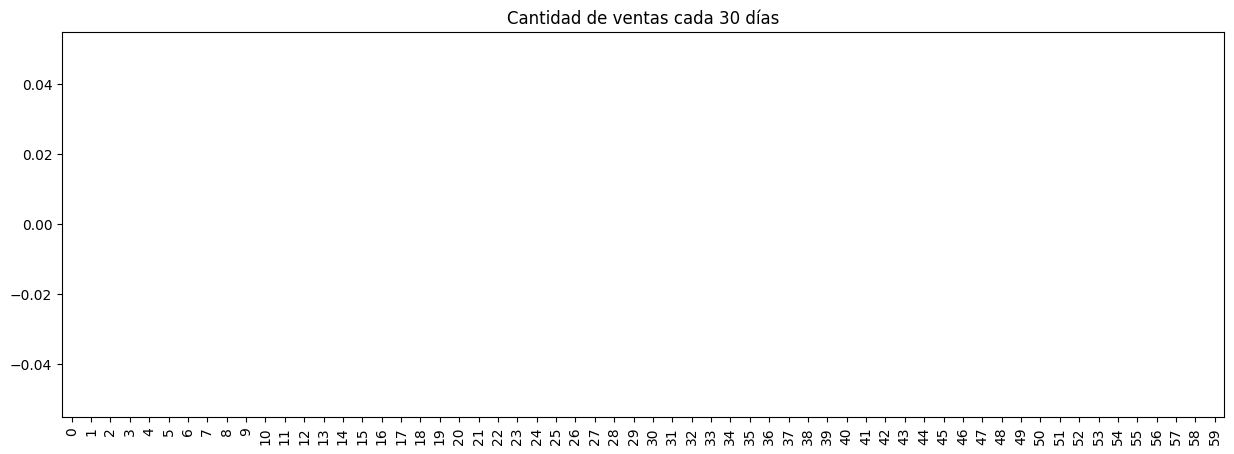

In [16]:
longitud = []
for elemento in lista_mensual:
    longitud.append(len(elemento.dropna()))

pd.Series(longitud).plot.bar(figsize=(15, 5)).set(
    title="Cantidad de ventas cada 30 días"
)

In [17]:
# AttributeError: AxesSubplot.set() got an unexpected keyword argument 'style'
import matplotlib.pyplot as plt

### help (plt.axes.AxesSubplot.set())

In [18]:
# Habia una cuestion de ranking que queriamos tratar con este objetivo de cortar los datasets

# CREANDO LAS REPRESENTACIONES TEMPORALES (RESEARCH)
Para cada una de las variables, debería haber una representación temporal, en el que cada registro represente una día unicamente

In [19]:
# crear una pivot table. que en el indice tenga fechas, en las columnas tenga localidad, y que los valores sean la cantidad de clientes que tuvo.

pd.pivot_table(
    data, values="IdCliente", index="Fecha", columns="Localidad", aggfunc="count"
)

Localidad,Barrios unidos,Bogota,Engativa,Puente aranda,Suba,Usaquen
Fecha,,,,,,
2016-01-09,7.0,16.0,68.0,11.0,19.0,11.0
2016-01-10,6.0,19.0,37.0,4.0,22.0,8.0
2016-01-11,7.0,17.0,100.0,29.0,13.0,5.0
2016-01-12,5.0,14.0,107.0,5.0,17.0,12.0
2016-02-09,3.0,1.0,46.0,33.0,11.0,7.0
...,...,...,...,...,...,...
2020-10-02,5.0,17.0,79.0,11.0,13.0,NaN
2020-10-03,3.0,NaN,41.0,20.0,16.0,8.0
2020-11-01,2.0,2.0,49.0,12.0,14.0,9.0


In [20]:
# crear una pivot table como la anterior, que en los values tenga cantidad de empleados
pd.pivot_table(
    data, values="Empleado", index="Fecha", columns="Localidad", aggfunc="count"
)

print(
    "Al parecer por cada transacción hay un empleado, no hay 2 transacciones realizadas por el mismo empleado en 1 dia"
)

Al parecer por cada transacción hay un empleado, no hay 2 transacciones realizadas por el mismo empleado en 1 dia


In [21]:
data.Familia.unique()

array(['LLANTA', 'SERVICIOS', 'REENCAUCHE', 'LUBRICANTES', 'FILTROS', nan],
      dtype=object)